# Python Advanced

## Set Instance Attributes on the Fly

* `__getattribute__` is called for all attribute access, regardless of whether the attribute exists or not.
* `__getattr__` is called when an attribute is not found in `__getattribute__`
* Example from [here](https://medium.com/@satishgoda/python-attribute-access-using-getattr-and-getattribute-6401f7425ce6): 

In [8]:
class Yeah(object):
    def __init__(self, name):
        self.name = name
        
    # Gets called when an attribute is accessed
    def __getattribute__(self, item):
        print('__getattribute__ '+ item)
        # Calling the super class to avoid recursion
        return super(Yeah, self).__getattribute__(item)
        
    # Gets called when the item is not found via __getattribute__
    def __getattr__(self, item):
        print('__getattr__ '+ item)
        return super(Yeah, self).__setattr__(item, 'orphan')

In [3]:
y1 = Yeah('yes')
y1.name

__getattribute__ name


'yes'

In [4]:
y1.foo

__getattribute__ foo
__getattr__ foo


In [5]:
y1.foo

__getattribute__ foo


'orphan'

In [6]:
y1.goo

__getattribute__ goo
__getattr__ goo


In [7]:
y1.__dict__

__getattribute__ __dict__


{'name': 'yes', 'foo': 'orphan', 'goo': 'orphan'}

## Singleton

In [1]:
class Singleton:
    _instance = None

    def __new__(cls):
        if not cls._instance:
            cls._instance = super(Singleton, cls).__new__(cls)
        return cls._instance

o1 = Singleton()
o2 = Singleton()

o1 is o2

True

* `super(Singleton, cls)` returns a temporary object of the superclass, which in this case is object as every class in Python inherits from object by default
* `__new__(cls)` is a special method in Python classes that is responsible for instance creation. It takes the class (not the instance) as the first argument followed by any additional arguments if needs

## [AsyncIO](https://www.youtube.com/watch?v=K56nNuBEd0c)

* The `async` keyword makes a function (subroutine) a coroutine
    * Subroutines block the process, coroutines don't
* An `async` coroutine can have awaitable statements (starting with the `await` keyword) which specify where in the coroutine is safe to pause and yield control to other coroutines
    * `await` can only be put in front of a statement that is awaitable
    * `time.sleep(3)` is not awaitable. Its awaitable version is `asyncio.sleep(3)`
* `brew_coffee()` is not a regular function call. It returns a coroutine object which can be gathered with other coroutines
* Can either create a batch with `asyncio.gather` or a single task by `asyncio.create_task`
* To run the coroutines:
    * `await` the created task or batch, or
    * `asyncio.run` it (doesn't work in Jupyter)
* main function has an `await` statement now so it must become an `async` coroutine

In [1]:
import asyncio
import time

async def brew_coffee():
    print('Start brew_coffee()')
    await asyncio.sleep(3)
    print('End brew_coffee()')
    return 'Coffee ready'

async def toast_bagel():
    print('Start toast_bagel()')
    await asyncio.sleep(2)
    print('End toast_bagel()')
    return 'Bagel ready'

async def main1():
    start_time = time.time()

    #########################################################
    batch = asyncio.gather(brew_coffee(), toast_bagel())
    result_coffee, result_bagel = await batch
    #########################################################
    
    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f'Result of brew_coffee: {result_coffee}')
    print(f'Result of toast_bagel: {result_bagel}')
    print(f'Total execution time: {elapsed_time:.2f} seconds')

async def main2():
    start_time = time.time()

    #########################################################
    coffee_task = asyncio.create_task(brew_coffee())
    bagel_task = asyncio.create_task(toast_bagel())

    result_coffee = await coffee_task
    result_bagel = await bagel_task
    #########################################################

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f'Result of brew_coffee: {result_coffee}')
    print(f'Result of toast_bagel: {result_bagel}')
    print(f'Total execution time: {elapsed_time:.2f} seconds')


# asyncio.run(main1())    # RuntimeError: asyncio.run() cannot be called from a running event loop

main_task = asyncio.create_task(main2())
res = await main_task


Start brew_coffee()
Start toast_bagel()
End toast_bagel()
End brew_coffee()
Result of brew_coffee: Coffee ready
Result of toast_bagel: Bagel ready
Total execution time: 3.00 seconds


In [2]:
# simple version

import asyncio

async def brew_coffee():
    await asyncio.sleep(3)

async def main():
    coffee_task = asyncio.create_task(brew_coffee())
    result_coffee = await coffee_task

    # same way to call main(): await a asyncio created task
    # or asyncio.run(main()) which doesn't work in Jupyter

### AsyncIO and Multiprocessing

* Asyncio enables concurrency, but not parallelism by default
* You can achieve parallelism by integrating thread pools and process pools
* **Asyncio shines for I/O-bound workloads, like network calls and file operations**
* For CPU-bound tasks, multiprocessing may provide better utilization

In [3]:
# Example by ChatGPT, working when run by python but not in Jupyter

import asyncio
from concurrent.futures import ProcessPoolExecutor

def cpu_bound_task(n):
    import time
    time.sleep(2)
    return f'Task {n} result'

async def main():
    loop = asyncio.get_running_loop()
    with ProcessPoolExecutor() as executor:
        tasks = [loop.run_in_executor(executor, cpu_bound_task, i) for i in range(5)]
        res = await asyncio.gather(*tasks)
        print(res)

# if __name__ == '__main__':
#     asyncio.run(main())

### AsyncIO and Decorator

* [Need two decorators?](https://stackoverflow.com/questions/42043226/using-a-coroutine-as-decorator)
* [A decorator that can wrap both functions and coroutines](https://stackoverflow.com/questions/42043226/using-a-coroutine-as-decorator/77604618#77604618) -- using `inspect.iscoroutinefunction`

### AsyncIO for Fixings Registration

In [2]:
# __init__.py

import asyncio

data = None
data_ready = asyncio.Event()

async def get_data():
    global data
    # 模擬抓取資料的耗時操作
    await asyncio.sleep(3)
    data = {"key": "value"}
    data_ready.set()

def init():
    asyncio.create_task(get_data())

# 初始化
init()

In [5]:
# client code, bar is the pricing function

import asyncio
from concurrent.futures import ThreadPoolExecutor

data = None
data_ready = asyncio.Event()
executor = ThreadPoolExecutor(max_workers=1)

def prepare_data():
    # 模擬一個耗時計算
    import time
    time.sleep(5)
    return {"key": "value"}

async def get_data():
    global data
    loop = asyncio.get_event_loop()
    data = await loop.run_in_executor(executor, prepare_data)
    data_ready.set()

def bar():
    loop = asyncio.get_event_loop()
    if not data_ready.is_set():
        loop.run_until_complete(data_ready.wait())
    print(f"Data is ready: {data}")

async def main():
    await init()
    print("Doing other tasks while waiting for data...")
    await asyncio.sleep(1)
    print("Still doing other tasks...")
    bar()

async def init():
    asyncio.create_task(get_data())

# 執行範例
# asyncio.run(main())


## Computing Grid Summary

* 3 packages + workers env: 
* `qmagrid_server`
    * `multiprocessing.managers.BaseManager.register` shared data structures in the network
    * Shared `multiprocessing.Manager().Queue()` and `multiprocessing.Manager().dict()`: 
        * `waiting_q` (Queue)
        * `working_q` (dict)
        * `result_q` (dict)
        * `status_q` (dict)
        * `machine_q` (dict)
    * `multiprocessing.Manager()` data structures have lock so is safe
    * monitor by Plotly Dash displaying status queue contents
* `qmagrid_client`
    * Depends on the `Job` class in the worker package
    * Implements context manager `QMAGridExecutor` to send cloudpicked jobs to `waiting_q` and wait to collect results from `result_q`
```python
with QMAGridExecutor() as executor:
      executor.map(f, args_list)
```
* `qmagrid_worker`
    * cmd commands to run `start_one_worker`, `start_pct_workers`, `start_n_workers` and `stop_all_workers`
    * `start_n_workers` (`start_pct_workers`) simply `subprocess.Popen`s `start_one_worker` n times and start sending status report
    * `start_one_worker` checks `waiting_q` constantly and if there is a job, do the following
        * pop from `waiting_q` and push to `working_q`
        * run the job
        * pop from `working_q` and push the result to `result_q`
    * It does so as long as the corresponding status report remains in the `status_q`
    * Parses a config file to determine  (WIP)
        * Server IP (which grid?)
        * Percentage of all logical cores to contribute
* The `workers` env
    * Turn on workers in this env to make sure of consistent package versions
    * A watcher process watching a commands.txt on shared drive. Once the file is modified, execute the commands in it

## The QMA Python Package Summary

* Conveniently call requests on trades: 
    * `Swaption().NPV()`
        * Default instruments swaption is 1y10y
        * Can call Delta, Gamma, Vega, etc.
    * Live trade support
        * `Trade(12345678).NPV()`
    * Flexible requests
        * `BermudanSwaption().CalibrationInfo()`
    * Trade spec attributes
        * `Trade(12345678).notional()` or currency, etc. 
        * From trade JSON, not from the core library, but users don't need to know
* Singleton `MarketEnv` context manager class
* Config file:
    * Quants default `MarketEnv` to previous day EOD, while traders default to today LIVE
    * Default books and products for trade population, extendible to other businesses
    * Default env: prod, dev or pat
* Job scheduler: 
    * Which computers run which functions at what times with what arguments specified in a `scheduled_jobs.csv`
    * Examples:
        * Copytree
        * Check if a file exists at certain time and send email notifications
* Debug sheet generation
    * `Trade(12345678).excel_render()`
* `auto_spreadsheet()`
* AsyncIO for fixings registration

## List Comprehension With Multiple For Loops

The following are [equivalent](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions): 

In [1]:
[(x, y) for x in [1,2,3] for y in [3,1,4] if x != y]

[(1, 3), (1, 4), (2, 3), (2, 1), (2, 4), (3, 1), (3, 4)]

In [2]:
combs = []
for x in [1,2,3]:
    for y in [3,1,4]:
        if x != y:
            combs.append((x, y))
combs

[(1, 3), (1, 4), (2, 3), (2, 1), (2, 4), (3, 1), (3, 4)]

## Virtual Environments

* `python -m venv ".myenv"` to create
* `source .myenv/bin/activate` to activate on linux
* `.myenv/Scripts/activate.bat` to activate on windows 
* `deactivate` to deactivate

## [redbull.py](https://github.com/christophercylai/python/blob/main/redbull.py)

```python
r"""
This script keeps the computer awake by pressing right ctrl key every SEC seconds
Put this script in $USERPROFILE\Downloads for easy access
To setup using PowerShell:
> cd $env:USERPROFILE\Downloads
> python -m venv .venv
> .venv\Scripts\activate
> pip install --trusted-host files.pythonhosted.org --trusted-host pypi.org pyautogui
> python redbull.py
"""
import pyautogui
from time import sleep

SEC = 180
pyautogui.FAILSAFE = False

while True:
    sleep(SEC)
    pyautogui.press('ctrlright')
```

## Where Is My Python? 

In [1]:
import sys, os

os.path.dirname(sys.executable)

'/srv/conda/envs/notebook/bin'

## pip

* `pip uninstall` 只能在 shell 裡用，notebook 沒辦法用，因為會有 `continue? (y/n)`
* Configure pip to install from other server
    * `pip config -v list` 查 config 都去哪裡找（[so](https://stackoverflow.com/questions/28278207/python-cant-find-pip-ini-or-pip-conf-in-windows)）
    ```
        For variant 'global', will try loading 'C:\ProgramData\pip\pip.ini'
        For variant 'user', will try loading 'C:\Users\foobar\pip\pip.ini'
        For variant 'user', will try loading 'C:\Users\foobar\AppData\Roaming\pip\pip.ini'
        For variant 'site', will try loading 'C:\Python38\pip.ini'
    ```
    * 去這些 folder 建一個 `pip.ini` 裡面貼
    ```
        [global]
        timeout = 60
        index = https://repo.abc.com/repository/pypi-all/pypi
        index-url = https://repo.abc.com/repository/pypi-all/simple
        trusted-host = repo.abc.com
    ```
    * 也可以直接在 shell 執行下面四行，log 會自己顯示 config file 存到哪去了
    ```
        pip config set global.timeout 60
        pip config set global.index https://repo.abc.com/repository/pypi-all/pypi
        pip config set global.index-url https://repo.abc.com/repository/pypi-all/simple
        pip config set global.trusted-host repo.abc.com
    ```

## Code Packaging

* install locally
    * `cd` to the top project directory where `setup.py` is 
    * `python setup.py install` or `pip install .` or `pip install -e .` [for developer install](https://stackoverflow.com/questions/19048732/python-setup-py-develop-vs-install)
* [All license badges](https://gist.github.com/lukas-h/2a5d00690736b4c3a7ba)
* Upload to PyPI: `cd` to the top project directory where `setup.py` is 

```sh
git checkout 0.0.1
python setup.py sdist
twine check dist/*
twine upload --repository-url https://test.pypi.org/legacy/ dist/*
twine upload dist/*
```

* 每次 implement 一個新的 function，如果 test 裡需要 import，要記得先加進 `__init__.py` 裡
* Remove a package from PyPI
    * Login > your projects > pyminimax > Manage > Settings > Delete project
* [Deploying a Cython Package to PyPI](https://levelup.gitconnected.com/how-to-deploy-a-cython-package-to-pypi-8217a6581f09)
* [Building a conda package and uploading it to Anaconda Cloud (medium)](https://giswqs.medium.com/building-a-conda-package-and-uploading-it-to-anaconda-cloud-6a3abd1c5c52)
* [How to put a swig/pybind11 C++ project on pypi (so)](https://stackoverflow.com/questions/42656388/how-to-put-a-swig-pybind11-c-project-on-pypi)

## C and C++ Extensions

* CPython is the [reference implementation](https://en.wikipedia.org/wiki/Reference_implementation) of the Python programming language
* [Python Bindings: Calling C or C++ From Python (Real Python)](https://realpython.com/python-bindings-overview/)
    * ctypes
    * CFFI
    * pybind11：改自 Boost.Python，較快但只支援 c++11 或更新的版本
    * Cython
    * Other Solutions
        * SWIG
    * [這裡](https://github.com/diegoferigo/cmake-build-extension)說最常用的是 SWIG 和 pybind11
* [Building C and C++ Extensions with distutils (Python Doc)](https://docs.python.org/3/extending/building.html#building-c-and-c-extensions-with-distutils)
    * `python setup.py build` 會編譯 `ext_modules` 裡指定的 c code，但指定在這裡的 c code 需要是處理 PyObject 的才能在 Python 裡不透過 `ctypes` 直接呼叫
    * 如果 target machine 有 c/c++ compiler（linux 都有）可能可以直接 source distribute C extensions
    * [Mac OS 自帶 clang](https://stackoverflow.com/questions/33007724/can-a-c-program-run-on-mac-os)
    * Windows 不一定有 compiler 所以至少需要 Windows Wheel
* [cibuildwheel](https://github.com/pypa/cibuildwheel)
    * GitHub Actions building wheels in all common platforms
    * by [Python Packaging Authority](https://www.pypa.io/en/latest/), also see [Python Packaging User Guide](https://packaging.python.org/)
* [cmake-build-extension](https://github.com/diegoferigo/cmake-build-extension)
    * Setuptools extension to build and package CMake projects
    * CMake 自帶 SWIG 和 pybind11 support。這個包把 setuptools 和 CMake 接起來，可以直接在 setup.py configure CMake project

### SWIG

* 要先 `sudo apt install swig`
* [Official Doc](http://www.swig.org) 和 David "Mr. Swig" Beazley 寫的 [PyCon 2008 slides](http://www.dabeaz.com/SwigMaster/SWIGMaster.pdf)
* 可以把 c/c++ 接到多種語言，只要寫同一份 interface files (*.i)
* 如果 Extension source files 裡有 interface file，distutils/setuptools 會自動跑 SWIG。看 [Python doc](https://docs.python.org/3.6/distutils/setupscript.html#extension-source-files) 和 [PyCon 2008 slides](http://www.dabeaz.com/SwigMaster/SWIGMaster.pdf) 第 22 頁
    * 應該是這台機器上要先灌好 SWIG 才行
    * 所以應該沒辦法直接 source distribute *.i
    * 如果一台機器上有 c/c++ compiler，倒是可以 source distribute SWIG 產生的 wrapper
    * [Python doc](https://docs.python.org/3.6/distutils/setupscript.html#extension-source-files) 示範了怎麼 package SWIG：在 setup 裡放 `py_modules=['foo'],` 和 `ext_modules=[Extension('_foo', ['foo.i'], swig_opts=['-modern', '-I../include'])],`
* Python module [必需是 so 或 pyd file](https://docs.python.org/3/extending/building.html#building-c-and-c-extensions-with-distutils)，而且原碼的 c 函數 input/output type 要是 PyObject。SWIG 只負責看著正常的 c 函數寫 wrapper
* [這裡](https://www.youtube.com/watch?v=g8--GrdlqGw)有講怎麼接 numpy array
* [也有可以從 c++ 呼叫 Python 函數](https://stackoverflow.com/questions/12392703/what-is-the-cleanest-way-to-call-a-python-function-from-c-with-a-swig-wrapped)
* 更多 c++ class 相關看[這裡](http://www.swig.org/Doc1.3/SWIGDocumentation.html#SWIGPlus)
* Example
    * `swig -c++ -python libswig.i` 產生 `libswig_wrap.cxx` 和 `libswig.py`
        * `libswig.py` 是 module frond end
        * `libswig_wrap.cxx` 是 wrapper code，裡面有 input/output type 都是 PyObject 的 c 函數
        * 這兩個檔是 portable，和平台無關。所有有 c 編譯器的機器上都可以編譯這個 Python module，也不需要 SWIG
        * 如果只是 c code 而沒有 c++ 可以省略 `-c++` flag：`swig -python libswig.i`，產生出來的 wrapper 會是 `libswig_wrap.c` 而不是 cxx
        * 用 g++ 編譯 c++，用 gcc 編譯 c
    * 把 `libswig_wrap.cpp` 和 `libswig.cxx` 一起編譯。`-I` 是 include，後面的 path 裡放了 Python 相關的 header files，例如 `Python.h`

```cpp
// libswig.cpp

#include "libswig.hpp"

std::vector<int> my_range(int n){   
    
    std::vector<int> vec = {};
    for (int i=0 ; i<n ; i++)
    {
        vec.push_back(i);
    }
    return vec;    
}
double square(double x){
    return x*x;
}
double cube(double x){
    return x*x*x;
}
```

```cpp
// libswig.hpp

#include<vector>

std::vector<int> my_range(int n);
double square(double x);
double cube(double x);
```

```cpp
// libswig.i

%module libswig
%{
#include "libswig.hpp"
%}
#define __version__ "0.0.1";
std::vector<int> my_range(int n);    // or simply  %include "libswig.hpp"
double square(double x);
double cube(double x);
```

In [1]:
!swig -c++ -python libswig.i

In [2]:
!g++ -fPIC -c libswig.cpp libswig_wrap.cxx -I/srv/conda/envs/notebook/include/python3.7m

In [3]:
!g++ -shared libswig.o libswig_wrap.o -o _libswig.so

In [4]:
import libswig

libswig.__version__, libswig.square(5), libswig.cube(5), libswig.my_range(5)

('0.0.1',
 25.0,
 125.0,
 <Swig Object of type 'std::vector< int > *' at 0x7ff1047bcea0>)

### Cython

* Example from [here](https://github.com/shekhar270779/Learn_Pandas/blob/master/Cython%20in%20Jupyter-notebook.ipynb) and [this tutorial](https://www.youtube.com/watch?v=CC0IkiNByV4)
* `pip install Cython`
* `%%cpython` 開頭的 cell 會被 cython 編譯，`%%cpython -a` 可以看哪一行有回到 python
* Python code 寫好之後 type 所有變數。type casting 用例如 `<double> i`
* 函數可以宣告成 def，cdef 或 cpdef
* [不好 debug](https://stackoverflow.com/questions/32888501/debug-cython-code-pyx-when-using-the-python-debugger-pdb-best-practice)
* 實測不能 decorate cpdef 函數（為什麼？）
* 實測非 level one function（例如函數裡的函數）不能 cpdef

In [1]:
%load_ext cython

In [8]:
# Python version
def pyfac_loop(n):
    r = 1.0
    for i in range(1, n+1):
        r *= i
    return r

In [16]:
%%cython -a
cpdef double cyfac_loop(int n):
    cdef double r = 1.0
    cdef int i
    for i in range(1, n+1):
        r *= <double>i
    return r

In [6]:
%timeit pyfac_loop(20)
%timeit cyfac_loop(20)

1.37 µs ± 26.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
74.3 ns ± 1.12 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


#### Units of Measure Less Than a Second 

| Multiple of a second | Unit          | Symbol |
|----------------------|---------------|--------|
| $10^{-9}$            | 1 nanosecond  | 1 ns   |
| $10^{-6}$            | 1 microsecond | 1 µs   |
| $10^{-3}$            | 1 millisecond | 1 ms   |

#### Integral Types

In [24]:
%%cython

# cdef is an directive , telling objects are c objects
cdef:
    int i = 0
    unsigned long j = 1
    signed short k = -3
    bint flag = True
    long long ll = 1LL
    float a = 1.0
    double b = -2.0
    long double c= 1e5
    str s = "abc"
    
    
print(i, j, k, ll, flag, a, b, c, s)    

0 1 -3 1 True 1.0 -2.0 100000.0 abc


#### cimport

In [15]:
%%cython 

import datetime            
cimport cpython.datetime   # 用這個取代上面那行

import array
cimport cpython.array

import numpy as np # gives access to python functions
cimport numpy as np # gives you access to Numpy C API ---> 有 warning？不能用了？

from libc.math cimport exp       # 用 c 函數會比 numpy 版本快很多
from libc.stdlib cimport rand  

cdef extern from "limits.h": 
    int RAND_MAX

In file included from /srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969,
                 from /srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /home/jovyan/.cache/ipython/cython/_cython_magic_2014508b603b08191838a4a9c4c94518.c:648:
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


### ctypes

* 在 Python 自帶的 standard library 裡，不需另外安裝
* 用正常的 c code 就好，signature 不需要用 PyObject
* 編譯成 shared object（*.so）再手動在 python 端指定 input/output type

```c
// lib.c

double square(double x){
    return x*x;
}
double cube(double x){
    return x*x*x;
}
```

In [5]:
!gcc -fPIC -shared -o lib.so lib.c

In [1]:
import ctypes

lib = ctypes.CDLL('./lib.so')

lib.square.argtypes = [ctypes.c_double]
lib.square.restype = ctypes.c_double

lib.cube.argtypes = [ctypes.c_double]
lib.cube.restype = ctypes.c_double

lib.square(5), lib.cube(5)

(25.0, 125.0)

## Entry Points

* 用 python 寫像 pytest 一樣的 cli command [還沒看](https://amir.rachum.com/blog/2017/07/28/python-entry-points/)

## [Always Use](http://jaredgrubb.blogspot.com/2009/04/python-is-none-vs-none.html) `is None` instead of `==None`

* `==` 比的是值，`is` 比位址（`None` 是 singleton）
    * 所以 `is None` 比 `==None` 快一點點
* `==` 可能被 overload（`__eq__`），使得 `==None` 出現不可預期的結果

## Import in a `with` Statement

出了 `with` 仍然有用

In [1]:
import numpy as np

class context:
    def __enter__(self):
        pass
    
    def __exit__(self, exc_type=None, exc_value=None, traceback=None):
        pass
    
with context():
    from pandas import DataFrame
    print(DataFrame(np.arange(10).reshape(2, 5)))

print(DataFrame(np.arange(10).reshape(2, 5)))    

   0  1  2  3  4
0  0  1  2  3  4
1  5  6  7  8  9
   0  1  2  3  4
0  0  1  2  3  4
1  5  6  7  8  9


## [Bytes and Str](https://betterprogramming.pub/strings-unicode-and-bytes-in-python-3-everything-you-always-wanted-to-know-27dc02ff2686)

* Unicode 是 ASCII 的 superset，把字元映到數字（或[碼位，code points](https://zh.wikipedia.org/zh-tw/%E7%A0%81%E4%BD%8D)）
    * 例如 ASCII 表有 128 個碼位，從 16 進位的 00 到 7F
    * Python 3 開始 `str` 是 Unicode string
* 如果所有 code point 都統一用一樣大的空間來存，會很浪費空間。最原始的 ASCII 就只需要 7 個 bits 就存的下了
* UTF-8 是把 code points 存起來的 standard
    * by far the most popular，世界流量排名前 1000 的網頁中有 97% 是用 UTF-8
    * Python 3 default for `str.encode()` and `bytes.decode()`
* 所有的 string 都要 specify encoding 不然就沒辦法讀
* Python 3 `bytes` is a binary serialization format represented by a sequence of 8-bits integers that is fit for storing data on the file system or sending it across the Internet

## Multiprocessing vs. Threading

* See [this SO post](https://stackoverflow.com/questions/3044580/multiprocessing-vs-threading-python). The threading module uses threads, the multiprocessing module uses processes. The difference is that threads run in the same memory space, while processes have separate memory. 一個 process 有自己的獨立的記憶體，甚至 IO，所以 multiprocessing 比較難 share objects。而寫 thread 的時候則要注意同時把資料寫進同一塊記憶體是否安全
* 在 windows，multiprocessing 會很慢，因為每個 process 都重新 new 一個 python interpreter session，在 Unix-like systems 不用。看[這個 SO post](https://stackoverflow.com/questions/28744046/multiprocessing-python-not-running-in-parallel)

## [Making Command Line Commands Using Python](https://dbader.org/blog/how-to-make-command-line-commands-with-python)

* This app can git clone multiple repos with token: 
    ```
    gc repo_name_1 repo_name_2
    ```
* Need pycrypto to run, which requires gcc: `apt-get install gcc`, `pip install pycrypto`
* Step by step: 
    1. create a new file named `gc`
    1. copy and paste below into `gc`
    1. `chmod +x gc`
    1. make sure the path of `gc` is in `$PATH`: `export PATH=$HOME/binder:$PATH'` if `gc` is in `$HOME/binder`
* Implementation details    
    * ```#!/usr/bin/env``` tells the shell this script should be run by python
        * no matter where python is installed, ```#!/usr/bin/env``` will lead the shell to the right location
    * Both the key and the initial vector of ```AES.new``` need to be 16 bytes
    * Both encrypt and decrypt output binary which needs to be decoded to string
    * When calling ```gc repo1 repo2```, ```sys.argv``` will be ```['gc', 'repo1', 'repo2']```

In [ ]:
#!/usr/bin/env python
from Crypto.Cipher import AES
from getpass import getpass
import subprocess, sys

password = getpass()
# o1 = AES.new(password.ljust(16), AES.MODE_CFB, '*'*16)
# encrypted = o1.encrypt(LONG_AND_HARD_TO_REMEMBER_TOKEN)

encrypted = b'!>k\x98%6\x9e,j\x88\xd8\x13\xa85Z#\xdb\xa5Q\xb2\xfc^\x15\xd6\xe6mH=\xb9\xe4~\x88\xea\x8f\xe2M\xc1\xf6\xec\xcd'
aes = AES.new(password.ljust(16), AES.MODE_CFB, '*'*16) # key and initial vector both need to be 16 byptes
token = aes.decrypt(encrypted).decode()

for repo in sys.argv[1:]:
    subprocess.run(['git', 'clone', f'https://{token}@github.com/beginnerSC/{repo}'])

## [Bare Asterisk (*)](https://stackoverflow.com/questions/14301967/bare-asterisk-in-function-arguments) and [Bare Forward Slash (/)](https://stackoverflow.com/questions/56514297/bare-forward-slash-in-python-function-definition) in Function Arguments

* ```def foo(a, b, *, c, d):``` 強制呼叫函數時傳入 ```c``` 和 ```d``` 一定要寫 ```c=``` 和 ```d=```（named arguments）
* ```def foo(a, b, /, c, d):``` 強制呼叫函數時傳入 ```a``` 和 ```b``` 一定不能寫 ```a=``` 和 ```b=```（positional arguments），只能照順序把參數傳進去
    * python 3.8 以後才有，所以這個 Jupyter 環境目前沒有：

In [9]:
import sys
print(sys.version)

3.7.8 | packaged by conda-forge | (default, Nov 27 2020, 19:24:58) 
[GCC 9.3.0]


## Immutability and Hashing

* [SO discussion](https://stackoverflow.com/questions/2671376/hashable-immutable)
    * immutable object 初始化之後就不能改變了，mutable 的可以
    * mutable object 例如 list 預設不能 hash。可以自己寫 ```__hash__```，如果 list 的內容被改變了 hash 也要跟著變
* primitive types 之中 mutable 的只有 ```dict```，```list``` 跟 ```set```。下面的表來自這個 [medium post](https://medium.com/@meghamohan/mutable-and-immutable-side-of-python-c2145cf72747)

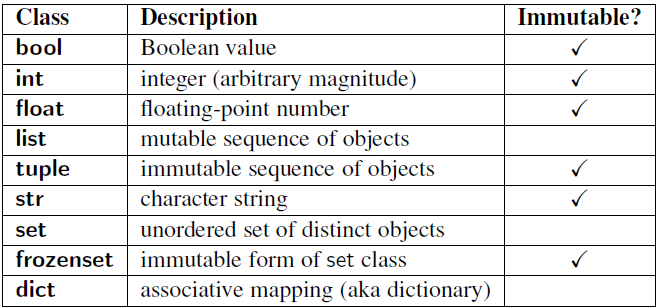

## ```if __name__ == "__main__":```

* 當一個 script 被當作 entry point 執行時 ```__name__``` 會被設成 ```"__main__"```
* 如果是被當作 module include，```__name__``` 會被設成該 script 的檔名

## Context Manager (the ```with``` Statement)

* [SO discussion](https://stackoverflow.com/questions/1984325/explaining-pythons-enter-and-exit)
* The following are equivalent: 

In [ ]:
# try block

SET_THINGS_UP
try: 
    DO_SOMETHING
finally:
    TEAR_THINGS_DOWN

# with statement

class controlled_execution:
    def __enter__(self):
        SET_THINGS_UP
        return THING
    def __exit__(self, exc_type, exc_value, traceback):
        TEAR_THINGS_DOWN
        
with controlled_execution as THING:
    SOME_CODE

* controlled_execution is a context manager class which implements ```__enter__()``` and ```__exit__()```. The return value of ```__enter__()```, if provided, is assigned to the variable followed by ```as```

In [10]:
import numpy as np

class fix_seed:
    def __init__(self, seed=0):
        self.seed = seed
        
    def __enter__(self):
        np.random.seed(self.seed)
    
    def __exit__(self, exc_type=None, exc_value=None, traceback=None):
        np.random.seed()
        
with fix_seed(seed=0):
    print(np.random.uniform())
print(np.random.uniform())

0.5488135039273248
0.9087389795050141


## itertools.groupby

* 在把 data 丟進 groupby 裡之前必需是已經 sorted by key
* key 的用法和 sorted 一模一樣
* 迴圈裡的每一個 g 都是 iterator

In [6]:
import itertools

data = 'trust but verify by unittest'
keyfunc = None

groups = []
uniquekeys = []
data = sorted(data, key=keyfunc)
for k, g in itertools.groupby(data, keyfunc):
    groups.append(list(g))      # store group iterator as a list
    uniquekeys.append(k)

from pprint import pprint
print('keys: ', uniquekeys)
print('groups: ')
pprint(groups)

keys:  [' ', 'b', 'e', 'f', 'i', 'n', 'r', 's', 't', 'u', 'v', 'y']
groups: 
[[' ', ' ', ' ', ' '],
 ['b', 'b'],
 ['e', 'e'],
 ['f'],
 ['i', 'i'],
 ['n'],
 ['r', 'r'],
 ['s', 's'],
 ['t', 't', 't', 't', 't', 't'],
 ['u', 'u', 'u'],
 ['v'],
 ['y', 'y']]


## collections

### deque

* 用 doubly linked list 寫成，左右兩端插入刪除都是 O(1)
* 也有 [circular array implementation](https://youtu.be/IITnvmnfi_Y?t=236)
    * 用兩個 index 指向兩端，因為是 circular array 所以沒有 index out of range 的問題
    * 如果 push 到空間不夠就 resize，向系統要更多空間重抄一次（takes $O(n)$ operations）重抄的時候用 0 當 start index
    

### Counter

* Dictionary of element frequencies of a list

In [4]:
import collections

collections.Counter('aaabbccccddeffffg')

Counter({'a': 3, 'b': 2, 'c': 4, 'd': 2, 'e': 1, 'f': 4, 'g': 1})

### OrderedDict

* [python doc](https://docs.python.org/3/library/collections.html#collections.OrderedDict)
* 記得輸入順序的 dict，比 dict 多了兩個 method：
    * ```popitem(last=True)```
    * ```move_to_end(key, last=True)```
* ```last=True``` 代表要 pop 最後一個 item，move_to_end 也是，如果用 ```last=False``` 變成 pop 第一個 item 和 move 到 beginning
* Implementation 是用 doubly linked list 來維持順序，再用 hash table 記下指標指向對應的 node
* 可以用來寫 LRU Cache

In [2]:
import collections

d = collections.OrderedDict()
d['e'] = 5
d['a'] = 1
d['b'] = 2
print(d)

d.move_to_end('a')
print(d)

OrderedDict([('e', 5), ('a', 1), ('b', 2)])
OrderedDict([('e', 5), ('b', 2), ('a', 1)])


### defaultdict

* [SO explanation](https://stackoverflow.com/questions/5900578/how-does-collections-defaultdict-work), [python doc](https://docs.python.org/3/library/collections.html#collections.defaultdict)
* access 沒加過的 key 也不會有 key error 而是回傳 default value
* 要輸入一個 callable 當作 default_factory 例如 ```collections.defaultdict(int)```，default value 是這個 callable 的傳回值

## Functional Programming

* Pure function on immutable data
    * 如果用 mutable 到 multithread 的時候就要擔心同步問題
    * 不要用 list of dictionaries，用 tuple of collections.namedtuple，完全 immutable
* Pure function：每次執行結果都一樣，no access to global states，也不能改變 input（即使是 mutable）
* Higher Order Functions
    * ```filter(function, iterable)```
    * ```map(function, iterable, ...)```
    * ```functools.partial(func, /, *args, **keywords)```
    * ```functools.reduce(function, iterable[, initializer])```
* helper functions
    * ```zip(*iterables)```
    * any, all
    * enumerate
    * sort
    * [itertools](https://docs.python.org/3/library/itertools.html)：一些常用的 iterator
* 其實用 list comprehension 就可以取代 filter 和 map 了

## Exception

* [Corey Schafer tutorial](https://www.youtube.com/watch?v=NIWwJbo-9_8)

In [ ]:
try: 
    pass
except ValueError as error:  # 如果抓到 ValueError 就跑這裡
    pass
except TypeError as error:   # 如果抓到 TypeError 就跑這裡
    pass
except Exception as error:   # 任何其它 Exception 跑這裡。越 general 的要放越下面
    pass
else:                        # 完全沒抓到 Exception 就跑這裡
    pass
finally:                     # 不管有沒有 Exception 都會跑到這裡
    pass

In [7]:
try:
    f = open('circles_.py')
except FileNotFoundError as e:
    print(e)
else:
    print(f.readline())
    f.close()
finally:
    print('Done!')

[Errno 2] No such file or directory: 'circles_.py'
Done!


## unittest
* [Socratica video](https://www.youtube.com/watch?v=1Lfv5tUGsn8) 8 分鐘極簡版
* [Corey Schafer 40 min](https://www.youtube.com/watch?v=6tNS--WetLI)
* unittest test case methods 名稱一定要以 test 開頭，但 module 名稱不限
* 跑 unittest：可以指定 module 也可以不指定（```m``` 是當作 module 來跑）
    * ```python -m unittest test_circles.py```
    * ```python -m unittest test_circles```
    * ```python -m unittest```
* 不指定時 python 用 test discovery 抓所有名稱以 test 開頭的 test case method 來跑
* 如果在 test_circles.py 裡加這個就可以直接 ```python test_circles.py```
    ```
    if __name__ == '__main__':
        unittest.main()
    ```
* ```misc/pycircle``` 裡有 minimum python module with unittests，可以在 misc/ 下跑 ```python -m unittest```
* 每次 library 在使用中出錯時，修好後應該去對應的地方加一個相關的 test 保證以後不再出現同樣的錯
* ```setUp``` 和 ```tearDown```
    * ```setUp``` 在每一次 test case method 開始前先執行
    * ```tearDown``` 在每一次 test case method 結束後執行
    * ```setUpClass``` 在所有 test case method 開始前先執行一次
    * ```tearDownClass``` 在所有 test case method 結束前執行一次
* 所有 test case method 不一定會照順序執行，所以他們之間一定要獨立
* [unittest.mock.patch](https://youtu.be/6tNS--WetLI?t=1723) 沒看
* 一個 test script 的 `if __name__=='__main__': ` 裡面是寫 `unittest.main()`。看 [unittest doc](https://docs.python.org/3/library/unittest.html#basic-example)

In [10]:
# circles.py

from math import pi

def circle_area(r):
    if type(r) not in [int, float]:
        raise TypeError("The radius must be a non-negative real number.")
    
    if r < 0:
        raise ValueError("The radius cannot be negative")
    
    return pi*(r**2)

In [ ]:
# test_circles.py

import unittest
from circles import circle_area
from math import pi

class TestCircleArea(unittest.TestCase):
    @classmethod
    def setUpClass(cls):
        pass
    
    @classmethod
    def tearDownClass(cls):
        pass
    
    def setUp(self):
        pass
    
    def tearDown(self):
        pass
    
    def test_area(self):
        # Test areas when radius >= 0
        self.assertAlmostEqual(circle_area(1), pi)
        self.assertAlmostEqual(circle_area(0), 0)
        self.assertAlmostEqual(circle_area(2.1), pi*(2.1**2))
        
    def test_values(self):
        # Make sure value erros are raised when necessary
        self.assertRaises(ValueError, circle_area, -2)      # 寫法一
        with self.assertRaises(ValueError):                 # 寫法二，可以正常呼叫函數
            circle_area(-2)
        
    def test_types(self):
        # Make sure type errors are raised when necessary
        self.assertRaises(TypeError, circle_area, 3+5j)
        self.assertRaises(TypeError, circle_area, True)
        self.assertRaises(TypeError, circle_area, "radius")
        
if __name__ == '__main__':
    unittest.main()

In [14]:
# this works because the scripts are here

!python -m unittest test_circles
!python -m unittest

...
----------------------------------------------------------------------
Ran 3 tests in 0.000s

OK
...
----------------------------------------------------------------------
Ran 3 tests in 0.000s

OK


## PEP8 Naming Styles

* [RealPython tutorial](https://realpython.com/python-pep8/)

| Type | Style |
|---|---|
| MyClass | PascalCase |
| MY_CONST | CAPITAL_SNAKE_CASE | 
| mypackage | likethis |
| everything_else | snake_case |

## OOP

* [Corey Schafer Videos on OOP](https://www.youtube.com/playlist?list=PL-osiE80TeTsqhIuOqKhwlXsIBIdSeYtc)

### Sample Program

* From [Corey Schafer Video on Preparing for Python Interview](https://youtu.be/DEwgZNC-KyE?t=899)
* 重覆默寫這段 code 直到覺得自然為止

In [5]:
class Person:
    def __init__(self, name):
        self.name = name
    
    def reveal_identity(self):
        print(f"My name is {self.name}.")
        
class SuperHero(Person):
    def __init__(self, name, hero_name):
        super().__init__(name)
        self.hero_name = hero_name
        
    def reveal_identity(self):
        super().reveal_identity()
        print(f"And I'm {self.hero_name}.")
        
corey = Person('Corey')
corey.reveal_identity()

wade = SuperHero('Wade Wilson', 'Deadpool')
wade.reveal_identity()

My name is Corey.
My name is Wade Wilson.
And I'm Deadpool.


### classmethod and staticmethod

* staticmethods don't have access to anything. A good use is to [group util functions](https://stackoverflow.com/questions/2438473/what-is-the-advantage-of-using-static-methods-in-python)

In [5]:
class Employee:

    num_of_emps = 0
    raise_amt = 1.04

    def __init__(self, first, last, pay):
        self.first = first
        self.last = last
        self.email = first + '.' + last + '@email.com'
        self.pay = pay

        Employee.num_of_emps += 1

    def fullname(self):
        return '{} {}'.format(self.first, self.last)

    def apply_raise(self):
        self.pay = int(self.pay * self.raise_amt)

    @classmethod
    def set_raise_amt(cls, amount):
        cls.raise_amt = amount

    @classmethod
    def from_string(cls, emp_str):
        first, last, pay = emp_str.split('-')
        return cls(first, last, pay)

    @staticmethod
    def is_workday(day):
        if day.weekday() == 5 or day.weekday() == 6:
            return False
        return True


emp_1 = Employee('Corey', 'Schafer', 50000)
emp_2 = Employee('Test', 'Employee', 60000)

Employee.set_raise_amt(1.05)

print(Employee.raise_amt)
print(emp_1.raise_amt)
print(emp_2.raise_amt)

emp_str_1 = 'John-Doe-70000'
emp_str_2 = 'Steve-Smith-30000'
emp_str_3 = 'Jane-Doe-90000'

first, last, pay = emp_str_1.split('-')

#new_emp_1 = Employee(first, last, pay)
new_emp_1 = Employee.from_string(emp_str_1)

print(new_emp_1.email)
print(new_emp_1.pay)

import datetime
my_date = datetime.date(2016, 7, 11)

print(Employee.is_workday(my_date))

1.05
1.05
1.05
John.Doe@email.com
70000
True


### Inheritance

In [6]:
class Employee:

    raise_amt = 1.04

    def __init__(self, first, last, pay):
        self.first = first
        self.last = last
        self.email = first + '.' + last + '@email.com'
        self.pay = pay

    def fullname(self):
        return '{} {}'.format(self.first, self.last)

    def apply_raise(self):
        self.pay = int(self.pay * self.raise_amt)


class Developer(Employee):
    raise_amt = 1.10

    def __init__(self, first, last, pay, prog_lang):
        super().__init__(first, last, pay)
        self.prog_lang = prog_lang


class Manager(Employee):

    def __init__(self, first, last, pay, employees=None):
        super().__init__(first, last, pay)
        if employees is None:
            self.employees = []
        else:
            self.employees = employees

    def add_emp(self, emp):
        if emp not in self.employees:
            self.employees.append(emp)

    def remove_emp(self, emp):
        if emp in self.employees:
            self.employees.remove(emp)

    def print_emps(self):
        for emp in self.employees:
            print('-->', emp.fullname())


dev_1 = Developer('Corey', 'Schafer', 50000, 'Python')
dev_2 = Developer('Test', 'Employee', 60000, 'Java')

mgr_1 = Manager('Sue', 'Smith', 90000, [dev_1])

print(mgr_1.email)

mgr_1.add_emp(dev_2)
mgr_1.remove_emp(dev_2)

mgr_1.print_emps()

Sue.Smith@email.com
--> Corey Schafer


### Special Methods

In [7]:
class Employee:

    raise_amt = 1.04

    def __init__(self, first, last, pay):
        self.first = first
        self.last = last
        self.email = first + '.' + last + '@email.com'
        self.pay = pay

    def fullname(self):
        return '{} {}'.format(self.first, self.last)

    def apply_raise(self):
        self.pay = int(self.pay * self.raise_amt)

    def __repr__(self):
        return "Employee('{}', '{}', {})".format(self.first, self.last, self.pay)

    def __str__(self):
        return '{} - {}'.format(self.fullname(), self.email)

    def __add__(self, other):
        return self.pay + other.pay

    def __len__(self):
        return len(self.fullname())


emp_1 = Employee('Corey', 'Schafer', 50000)
emp_2 = Employee('Test', 'Employee', 60000)

# print(emp_1 + emp_2)

print(len(emp_1))


13


### Property Decorators - Getters, Setters, and Deleters

In [8]:
class Employee:

    def __init__(self, first, last):
        self.first = first
        self.last = last

    @property
    def email(self):
        return '{}.{}@email.com'.format(self.first, self.last)

    @property
    def fullname(self):
        return '{} {}'.format(self.first, self.last)
    
    @fullname.setter
    def fullname(self, name):
        first, last = name.split(' ')
        self.first = first
        self.last = last
    
    @fullname.deleter
    def fullname(self):
        print('Delete Name!')
        self.first = None
        self.last = None


emp_1 = Employee('John', 'Smith')
emp_1.fullname = "Corey Schafer"

print(emp_1.first)
print(emp_1.email)
print(emp_1.fullname)

del emp_1.fullname

Corey
Corey.Schafer@email.com
Corey Schafer
Delete Name!


## Generator

* [Difference between iterators and generators](https://stackoverflow.com/questions/2776829/difference-between-pythons-generators-and-iterators)
    * iterator is any object of a class that has ```__next__``` and ```__iter__``` methods (```___iter___``` returns self)
    * generator is a function that has ```yield```
    * iterator 是比較廣的概念（any generator is an iterator but not vice versa）generator 寫起來比較快，但 iterator 有 class 可以客製很多不同的行為
* ```x**2 for x in range(100) if x%2 == 1``` 是一個 generator expression

In [10]:
def pow2():
    n = 2
    while n < 1000:
        yield n
        n *= 2

print([i for i in pow2()])

a = pow2()

print(next(a))
print(next(a))
print(next(a))

[2, 4, 8, 16, 32, 64, 128, 256, 512]
2
4
8


## [Coroutine](https://www.youtube.com/watch?v=7AoANOGIDuM)

In [6]:
# 呼叫 next() 時會跑到 coro 裡的下一個 yield
# 然後可以用 send 把值傳進正在跑的函數裡，同時 send 也會 return yield 的結果

def coro():
    step = 0
    while True:
        received = yield step
        step += 1
        print(f'Received: {received}')

c = coro()
next(c)               # important! get to the first yield
print(c.send(100))

Received: 100
1


## Decorator 

* 寫的很好的 [RealPython tutorial](https://realpython.com/primer-on-python-decorators/#stateful-decorators)，整篇看完了但沒時間作筆記
* 被 decorate 過的函數呼叫 ```.__name__``` 或 ```.__doc__```（```help()```）的時候會叫到 wrapper 的，所以才需要用 ```@functools.wraps(func)``` 把 func 的 name 和 docstring 抄給 wrapper
* ```@debug``` 印下函數的 input/output，可以用寫 recursive 的時候 debug
* [classes as decorators](https://realpython.com/primer-on-python-decorators/#classes-as-decorators)，implement ```__init__``` 和 ```__call__```，可以存狀態，例如 lru_cache

### General Pattern (No Argument)

In [7]:
import functools

def decorator(func):
    @functools.wraps(func)
    def wrapper_decorator(*args, **kwargs):
        # Do something before
        value = func(*args, **kwargs)
        # Do something after
        return value
    return wrapper_decorator

### Decorator fix_seed

In [367]:
# fix_seed：固定 seed = 0 版本。離開函數 seed 會還原成 None

import numpy as np
import functools

def fix_seed(fnc):
    @functools.wraps(fnc)
    def wrapper_fix_seed(*args, **kargs):
        np.random.seed(0)
        res = fnc(*args, **kargs)
        np.random.seed()
        return res
    return wrapper_fix_seed

@fix_seed
def printRand():
    print(np.random.uniform())
    
printRand()
print(np.random.uniform())

0.5488135039273248
0.6161167995056092


In [377]:
# 接受 argument 版本，但變成一定要指定 seed

import numpy as np
import functools

def fix_seed(seed=0):
    def decorator_fix_seed(fnc):
        @functools.wraps(fnc)
        def wrapper_fix_seed(*args, **kargs):
            np.random.seed(seed)
            res = fnc(*args, **kargs)
            np.random.seed()
            return res
        return wrapper_fix_seed
    return decorator_fix_seed

@fix_seed(100)
def printRand():
    print(np.random.uniform())
    
printRand()
print(np.random.uniform())

0.5434049417909654
0.3289099673526439


In [6]:
# 可以指定也可以不指定。若不指定 seed 預設為 0。若要指定一定要寫 seed=

# 有指定 seed 的時候相當於 printRand = fix_seed(seed=0)(printRand)，所以 _func 是 None
# 不指定 seed 的時候則變成 printRand = fix_seed(printRand)          把 function 傳進去

import numpy as np
import functools

def fix_seed(_func=None, *, seed=0):
    def decorator_fix_seed(func):
        @functools.wraps(func)
        def wrapper_fix_seed(*args, **kwargs):
            np.random.seed(seed)
            res = func(*args, **kwargs)
            np.random.seed()
            return res
        return wrapper_fix_seed

    if _func:
        return decorator_fix_seed(_func)
    else:
        return decorator_fix_seed

    
# @fix_seed(0)   # TypeError: 'int' object is not callable
# @fix_seed(seed=0)
@fix_seed
def printRand():
    print(np.random.uniform())
    
printRand()
print(np.random.uniform())    

0.5488135039273248
0.13056825103667768
